In [1]:
!pip -q install librosa==0.10.1 soundfile pandas numpy scipy scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 7.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import iqr
import librosa
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import os
import math
import os, glob, math, warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_DIR = "/content/drive/MyDrive/Ilab"


HC_DIR = os.path.join(BASE_DIR, "HC_AH")
PD_DIR = os.path.join(BASE_DIR, "PD_AH")
DEMOGRAPHICS_CSV = os.path.join(BASE_DIR, "Demographics_age_sex.xlsx")
OUTPUT_CSV = os.path.join(BASE_DIR, "audio_features.csv")

print("HC_DIR:", HC_DIR)
print("PD_DIR:", PD_DIR)
print("DEMOGRAPHICS_CSV:", DEMOGRAPHICS_CSV)
print("OUTPUT_CSV:", OUTPUT_CSV)

HC_DIR: /content/drive/MyDrive/Ilab/HC_AH
PD_DIR: /content/drive/MyDrive/Ilab/PD_AH
DEMOGRAPHICS_CSV: /content/drive/MyDrive/Ilab/Demographics_age_sex.xlsx
OUTPUT_CSV: /content/drive/MyDrive/Ilab/audio_features.csv


In [5]:
#  Audio params
SR = 16000
FRAME_LEN = 0.025     # 25 ms
HOP_LEN   = 0.010     # 10 ms
N_FFT     = int(SR * FRAME_LEN)   # 400
HOP_S     = int(SR * HOP_LEN)     # 160

In [6]:
# Helpers
def list_audio(folder):
    exts = ("*.wav","*.mp3","*.flac","*.m4a")
    files=[]
    for e in exts:
        files += glob.glob(os.path.join(folder,"**",e), recursive=True)
    return sorted(files)

def load_wave(path, sr=SR):
    y, _ = librosa.load(path, sr=sr, mono=True)
    if y.size == 0:
        y = np.zeros(sr//2, dtype=float)

    y = librosa.util.normalize(y)
    return y, sr

def stats(v):
    v = np.asarray(v, dtype=float)
    if v.size == 0 or not np.isfinite(v).any():
        return dict(mean=0.0, std=0.0, med=0.0, min=0.0, max=0.0, iqr=0.0)
    return dict(
        mean=float(np.nanmean(v)),
        std =float(np.nanstd(v, ddof=1)) if v.size>1 else 0.0,
        med =float(np.nanmedian(v)),
        min =float(np.nanmin(v)),
        max =float(np.nanmax(v)),
        iqr =float(iqr(v)) if v.size>1 else 0.0,
    )

def add_stats_row(row, prefix, v):
    s = stats(v)
    for k, val in s.items():
        row[f"{prefix}_{k}"] = val

In [7]:
def extract_features_librosa(path):
    row = {"name": os.path.splitext(os.path.basename(path))[0]}

    try:
        row["duration_sec"] = float(librosa.get_duration(filename=path))
    except Exception:
        y_tmp, sr_tmp = load_wave(path, SR)
        row["duration_sec"] = float(len(y_tmp)/sr_tmp)

    # features
    y, sr = load_wave(path, SR)
    rms = librosa.feature.rms(y=y, frame_length=N_FFT, hop_length=HOP_S)[0]
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=N_FFT, hop_length=HOP_S)[0]
    add_stats_row(row, "rms", rms)
    add_stats_row(row, "zcr", zcr)

    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_S)) + 1e-9
    add_stats_row(row, "spec_centroid",  librosa.feature.spectral_centroid(S=S, sr=sr)[0])
    add_stats_row(row, "spec_bandwidth", librosa.feature.spectral_bandwidth(S=S, sr=sr)[0])
    add_stats_row(row, "spec_rolloff95", librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.95)[0])
    add_stats_row(row, "spec_flatness",  librosa.feature.spectral_flatness(S=S)[0])
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    add_stats_row(row, "spec_contrast",  np.mean(contrast, axis=0))

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=N_FFT, hop_length=HOP_S)
    d1   = librosa.feature.delta(mfcc, order=1)
    d2   = librosa.feature.delta(mfcc, order=2)
    for i in range(13):
        row[f"mfcc{i+1}_mean"]   = float(np.nanmean(mfcc[i]))
        row[f"mfcc{i+1}_std"]    = float(np.nanstd(mfcc[i], ddof=1)) if mfcc.shape[1]>1 else 0.0
        row[f"dmfcc{i+1}_mean"]  = float(np.nanmean(d1[i]))
        row[f"dmfcc{i+1}_std"]   = float(np.nanstd(d1[i], ddof=1)) if d1.shape[1]>1 else 0.0
        row[f"ddmfcc{i+1}_mean"] = float(np.nanmean(d2[i]))
        row[f"ddmfcc{i+1}_std"]  = float(np.nanstd(d2[i], ddof=1)) if d2.shape[1]>1 else 0.0

    try:
        f0, _, _ = librosa.pyin(y, fmin=50, fmax=600, sr=sr, frame_length=N_FFT, hop_length=HOP_S)
    except Exception:
        f0 = None
    if f0 is None or f0.size == 0:
        row.update({"f0_mean":0.0,"f0_std":0.0,"f0_med":0.0,"f0_min":0.0,"f0_max":0.0,"f0_range":0.0,"voiced_ratio":0.0})
    else:
        voiced = ~np.isnan(f0)
        f0v = f0[voiced]
        if f0v.size == 0:
            row.update({"f0_mean":0.0,"f0_std":0.0,"f0_med":0.0,"f0_min":0.0,"f0_max":0.0,"f0_range":0.0,
                        "voiced_ratio": float(np.mean(voiced)) if f0.size else 0.0})
        else:
            row["f0_mean"]   = float(np.mean(f0v))
            row["f0_std"]    = float(np.std(f0v, ddof=1)) if f0v.size>1 else 0.0
            row["f0_med"]    = float(np.median(f0v))
            row["f0_min"]    = float(np.min(f0v))
            row["f0_max"]    = float(np.max(f0v))
            row["f0_range"]  = float(np.max(f0v) - np.min(f0v))
            row["voiced_ratio"] = float(np.mean(voiced)) if f0.size else 0.0
    return row


hc_files = list_audio(HC_DIR)
pd_files = list_audio(PD_DIR)
print(f"Found {len(hc_files)} HC files, {len(pd_files)} PD files.")
assert len(hc_files)+len(pd_files) > 0, "No audio files found. Check HC_DIR/PD_DIR and file extensions."


rows=[]
for f in tqdm(hc_files, desc="HC"):
    r = extract_features_librosa(f); r["status"]=0; rows.append(r)
for f in tqdm(pd_files, desc="PD"):
    r = extract_features_librosa(f); r["status"]=1; rows.append(r)

df = pd.DataFrame(rows)
demographics_df = pd.read_excel(DEMOGRAPHICS_CSV)
df = df.merge(demographics_df[['Sample ID', 'Age', 'Sex']], how='left', left_on='name', right_on='Sample ID')



df.to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV, "shape:", df.shape)

Found 41 HC files, 40 PD files.


PD: 100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


Saved: /content/drive/MyDrive/Ilab/audio_features.csv shape: (81, 133)


In [8]:
df = df.drop(columns=['Sample ID'])
print(df)

                                                 name  duration_sec  rms_mean  \
0        AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5      3.738875  0.274526   
1        AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6      2.267375  0.173015   
2        AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2      2.867625  0.268246   
3        AH_123G_559F0706-2238-447C-BA39-DB5933BA619D      2.863500  0.230184   
4        AH_195B_39DA6A45-F4CC-492A-80D4-FB79049ACC22      4.210500  0.137945   
..                                                ...           ...       ...   
76  AH_545841223-24FB0419-5BAE-4F9C-8EBC-CD62DA6590D2      4.091500  0.073436   
77  AH_545841226-C699FC9E-1E0C-474D-A12A-936DD92B8980      7.208000  0.088663   
78  AH_545841227-5C77713A-66F1-49D0-BC8A-702C152E668D      1.516125  0.286944   
79  AH_545847410-D1BA3BB4-1F61-44CA-ACDE-455A8E97E04B      2.469250  0.177935   
80  AH_545880204-EE87D3E2-0D4C-4EAA-ACD7-C3F177AFF62F      5.630375  0.212662   

     rms_std   rms_med   rm

In [9]:

X = df.drop(columns=["name","status","Sex"]).apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True))
y = df["status"].astype(int)


In [10]:
print(df.shape)
print(df.info())
print(df.isna().sum())
print(df['status'].value_counts())

(81, 132)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Columns: 132 entries, name to Sex
dtypes: float64(129), int64(1), object(2)
memory usage: 83.7+ KB
None
name            0
duration_sec    0
rms_mean        0
rms_std         0
rms_med         0
               ..
f0_range        0
voiced_ratio    0
status          0
Age             0
Sex             0
Length: 132, dtype: int64
status
0    41
1    40
Name: count, dtype: int64


In [11]:
print(X.isna().sum())

duration_sec    0
rms_mean        0
rms_std         0
rms_med         0
rms_min         0
               ..
f0_min          0
f0_max          0
f0_range        0
voiced_ratio    0
Age             0
Length: 129, dtype: int64


In [12]:
# Replace 'M' with 1 (Male) and 'F' with 0 (Female)
df['Sex'] = df['Sex'].replace({'M': 1, 'F': 0})

# Check the first few rows to confirm the encoding
print(df[['Sex']].head())


   Sex
0    1
1    1
2    0
3    1
4    1


In [13]:
# Step 1: Mutual Information ranking
mi = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Take top 70 first (shortlist)
top70 = mi_scores.head(70).index.tolist()
X_short = X[top70]


In [14]:
# Step 2: Correlation pruning → avoid redundant features
corr = X_short.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.90)]

X_pruned = X_short.drop(columns=to_drop)
print("After pruning, features left:", X_pruned.shape[1])

# Step 3: Final top 50 (if still >50, keep top MI-ranked)
final50 = mi_scores[mi_scores.index.isin(X_pruned.columns)].head(50).index.tolist()
data = df[["name","status","Sex"] + final50]


OUTPUT50 = OUTPUT_CSV.replace("BASELINE.csv", "TOP50.csv")
data.to_csv(OUTPUT50, index=False)
print("Saved:", OUTPUT50, "shape:", data.shape)


data.head()


After pruning, features left: 63
Saved: /content/drive/MyDrive/Ilab/audio_features.csv shape: (81, 53)


name  status  Sex   Age  \
0  AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5       0    1  69.0   
1  AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6       0    1  43.0   
2  AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2       0    0  18.0   
3  AH_123G_559F0706-2238-447C-BA39-DB5933BA619D       0    1  28.0   
4  AH_195B_39DA6A45-F4CC-492A-80D4-FB79049ACC22       0    1  68.0   

   mfcc11_std  mfcc2_mean  dmfcc9_std   rms_max   rms_min  dmfcc10_std  ...  \
0    4.610625  228.812912    0.601470  0.373382  0.096240     0.523528  ...   
1    5.519061  240.440247    1.102100  0.370657  0.064733     0.788682  ...   
2    5.338386  214.156357    0.994124  0.353317  0.058942     0.756957  ...   
3    4.969622  248.918167    0.540703  0.299296  0.067374     0.615831  ...   
4    7.294173  213.273514    1.101072  0.301457  0.069612     0.772216  ...   

   mfcc10_mean  dmfcc1_std  dmfcc8_mean  ddmfcc11_std  spec_flatness_med  \
0     6.322218    1.636599    -0.039612      0.390529       6.944369e-07   
1    -1.362380    5.150826     0.005601      0.531919       9.341920e-07   
2    -1.771485    4.843583    -0.114848      0.701414       3.277591e-07   
3     6.870344    1.787335     0.033680      0.471825       9.465176e-07   
4    11.774856    2.210607    -0.000423      0.739769       1.908772e-06   

   ddmfcc3_mean  dmfcc5_std  mfcc4_std  mfcc10_std  ddmfcc8_std  
0      0.036834    0.757003   5.886789    4.504308     0.440780  
1      0.280168    1.669222  14.029616    5.649245     0.694394  
2      0.138050    1.244714  10.699762    5.739808     0.559391  
3      0.063588    0.816375   7.189028    4.659195     0.592326  
4      0.068279    1.294391   8.707542    5.358960     0.652235  

[5 rows x 53 columns]

In [15]:
data.describe()

status        Sex        Age  mfcc11_std  mfcc2_mean  dmfcc9_std  \
count  81.000000  81.000000  81.000000   81.000000   81.000000   81.000000   
mean    0.493827   0.456790  57.264198    6.692566  206.201637    0.964366   
std     0.503077   0.501233  15.371786    1.572498   26.409574    0.226276   
min     0.000000   0.000000  18.000000    4.473374  147.855453    0.452380   
25%     0.000000   0.000000  44.000000    5.582218  187.435593    0.804375   
50%     0.000000   0.000000  58.140000    6.345257  207.214691    0.977935   
75%     1.000000   1.000000  69.450000    7.455635  224.431351    1.102100   
max     1.000000   1.000000  85.310000   14.294031  258.299103    1.521098   

         rms_max    rms_min  dmfcc10_std  dmfcc6_std  ...  mfcc10_mean  \
count  81.000000  81.000000    81.000000   81.000000  ...    81.000000   
mean    0.384502   0.054911     0.878211    1.035257  ...     2.589992   
std     0.074609   0.039641     0.219375    0.235421  ...     7.133099   
min     0.221450   0.000250     0.509878    0.592897  ...   -19.901566   
25%     0.333550   0.023675     0.721264    0.881859  ...    -1.362380   
50%     0.373382   0.058653     0.846592    1.022665  ...     3.037073   
75%     0.423808   0.067040     0.996535    1.210990  ...     7.513796   
max     0.598379   0.231139     1.592290    1.652241  ...    14.776464   

       dmfcc1_std  dmfcc8_mean  ddmfcc11_std  spec_flatness_med  ddmfcc3_mean  \
count   81.000000    81.000000     81.000000       8.100000e+01     81.000000   
mean     3.899234    -0.003898      0.648338       8.391390e-07      0.105228   
std      1.599835     0.057617      0.123927       5.341651e-07      0.091858   
min      1.346464    -0.143317      0.390529       2.130291e-07     -0.054039   
25%      2.636112    -0.028244      0.556286       4.859087e-07      0.048842   
50%      3.744440    -0.001663      0.631437       7.158296e-07      0.087428   
75%      4.871034     0.019998      0.738843       1.054610e-06      0.138050   
max      9.757030     0.228874      1.051892       3.649879e-06      0.409993   

       dmfcc5_std  mfcc4_std  mfcc10_std  ddmfcc8_std  
count   81.000000  81.000000   81.000000    81.000000  
mean     1.156151  11.631688    6.492954     0.725168  
std      0.294647   5.444447    2.113646     0.133857  
min      0.532206   4.683805    3.714228     0.440780  
25%      0.946404   8.707542    5.159677     0.632824  
50%      1.117167  10.699762    6.084981     0.722852  
75%      1.344028  13.113283    7.178928     0.821272  
max      2.042968  48.262260   15.825049     1.064580  

[8 rows x 52 columns]

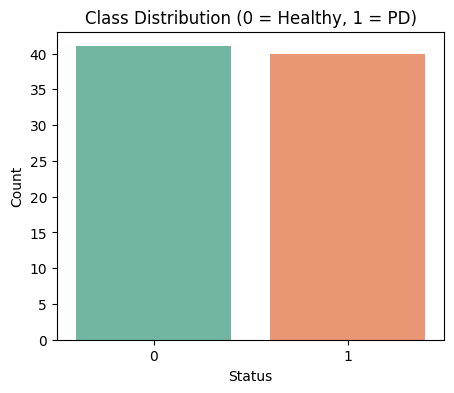

In [16]:
# Identify features
feature_cols = [c for c in data.columns if c not in ["name","status"]]


plt.figure(figsize=(5,4))
sns.countplot(x="status", data=data, palette="Set2")
plt.title("Class Distribution (0 = Healthy, 1 = PD)")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()


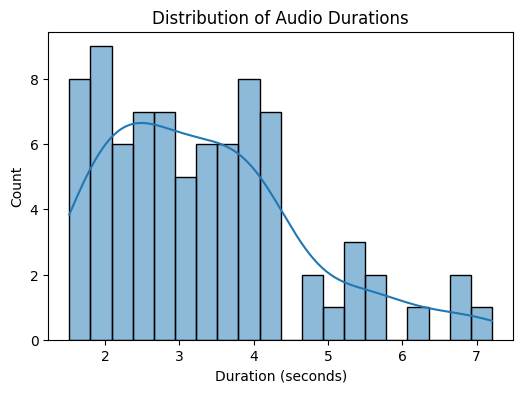

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(data["duration_sec"], kde=True, bins=20)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()


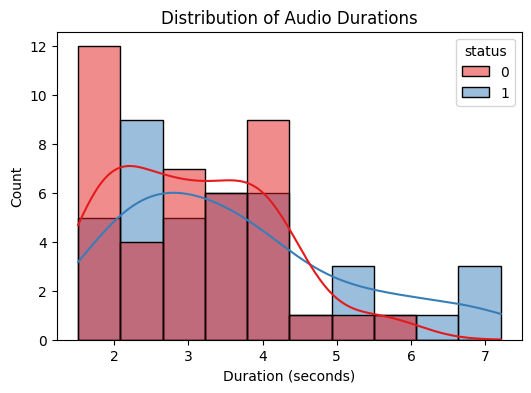

Average duration per class:
            mean       50%       min       max
status                                        
0       3.065027  2.867625  1.625250  5.763625
1       3.589625  3.324875  1.516125  7.208000


In [18]:
if "duration_sec" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x="duration_sec", hue="status", bins=10, kde=True, palette="Set1")
    plt.title("Distribution of Audio Durations")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Count")
    plt.show()

    print("Average duration per class:")
    print(df.groupby("status")["duration_sec"].describe()[["mean","50%","min","max"]])

In [19]:
df.columns

Index(['name', 'duration_sec', 'rms_mean', 'rms_std', 'rms_med', 'rms_min',
       'rms_max', 'rms_iqr', 'zcr_mean', 'zcr_std',
       ...
       'f0_mean', 'f0_std', 'f0_med', 'f0_min', 'f0_max', 'f0_range',
       'voiced_ratio', 'status', 'Age', 'Sex'],
      dtype='object', length=132)

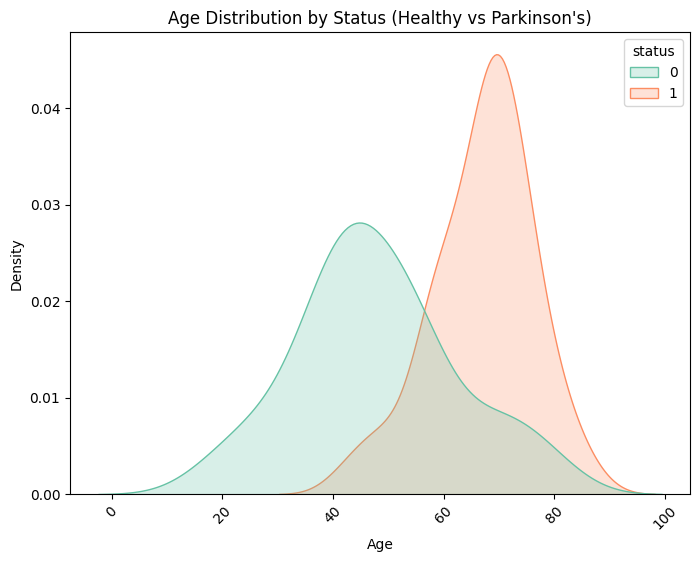

In [20]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x="Age", hue="status", fill=True, common_norm=False, palette="Set2")
plt.title("Age Distribution by Status (Healthy vs Parkinson's)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.xticks(rotation=45)
plt.show()


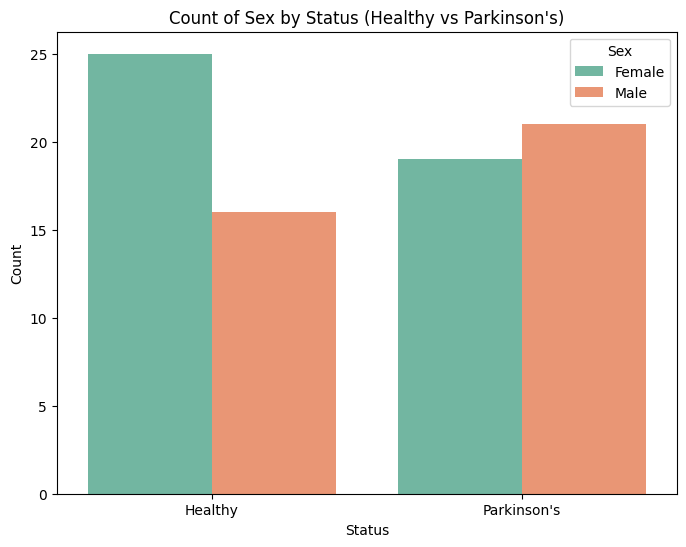

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(x="status", hue="Sex", data=df, palette="Set2")
plt.title("Count of Sex by Status (Healthy vs Parkinson's)")
plt.xlabel("Status")
plt.ylabel("Count")
plt.xticks([0, 1], ["Healthy", "Parkinson's"])
plt.legend(title="Sex", labels=["Female", "Male"])
plt.show()


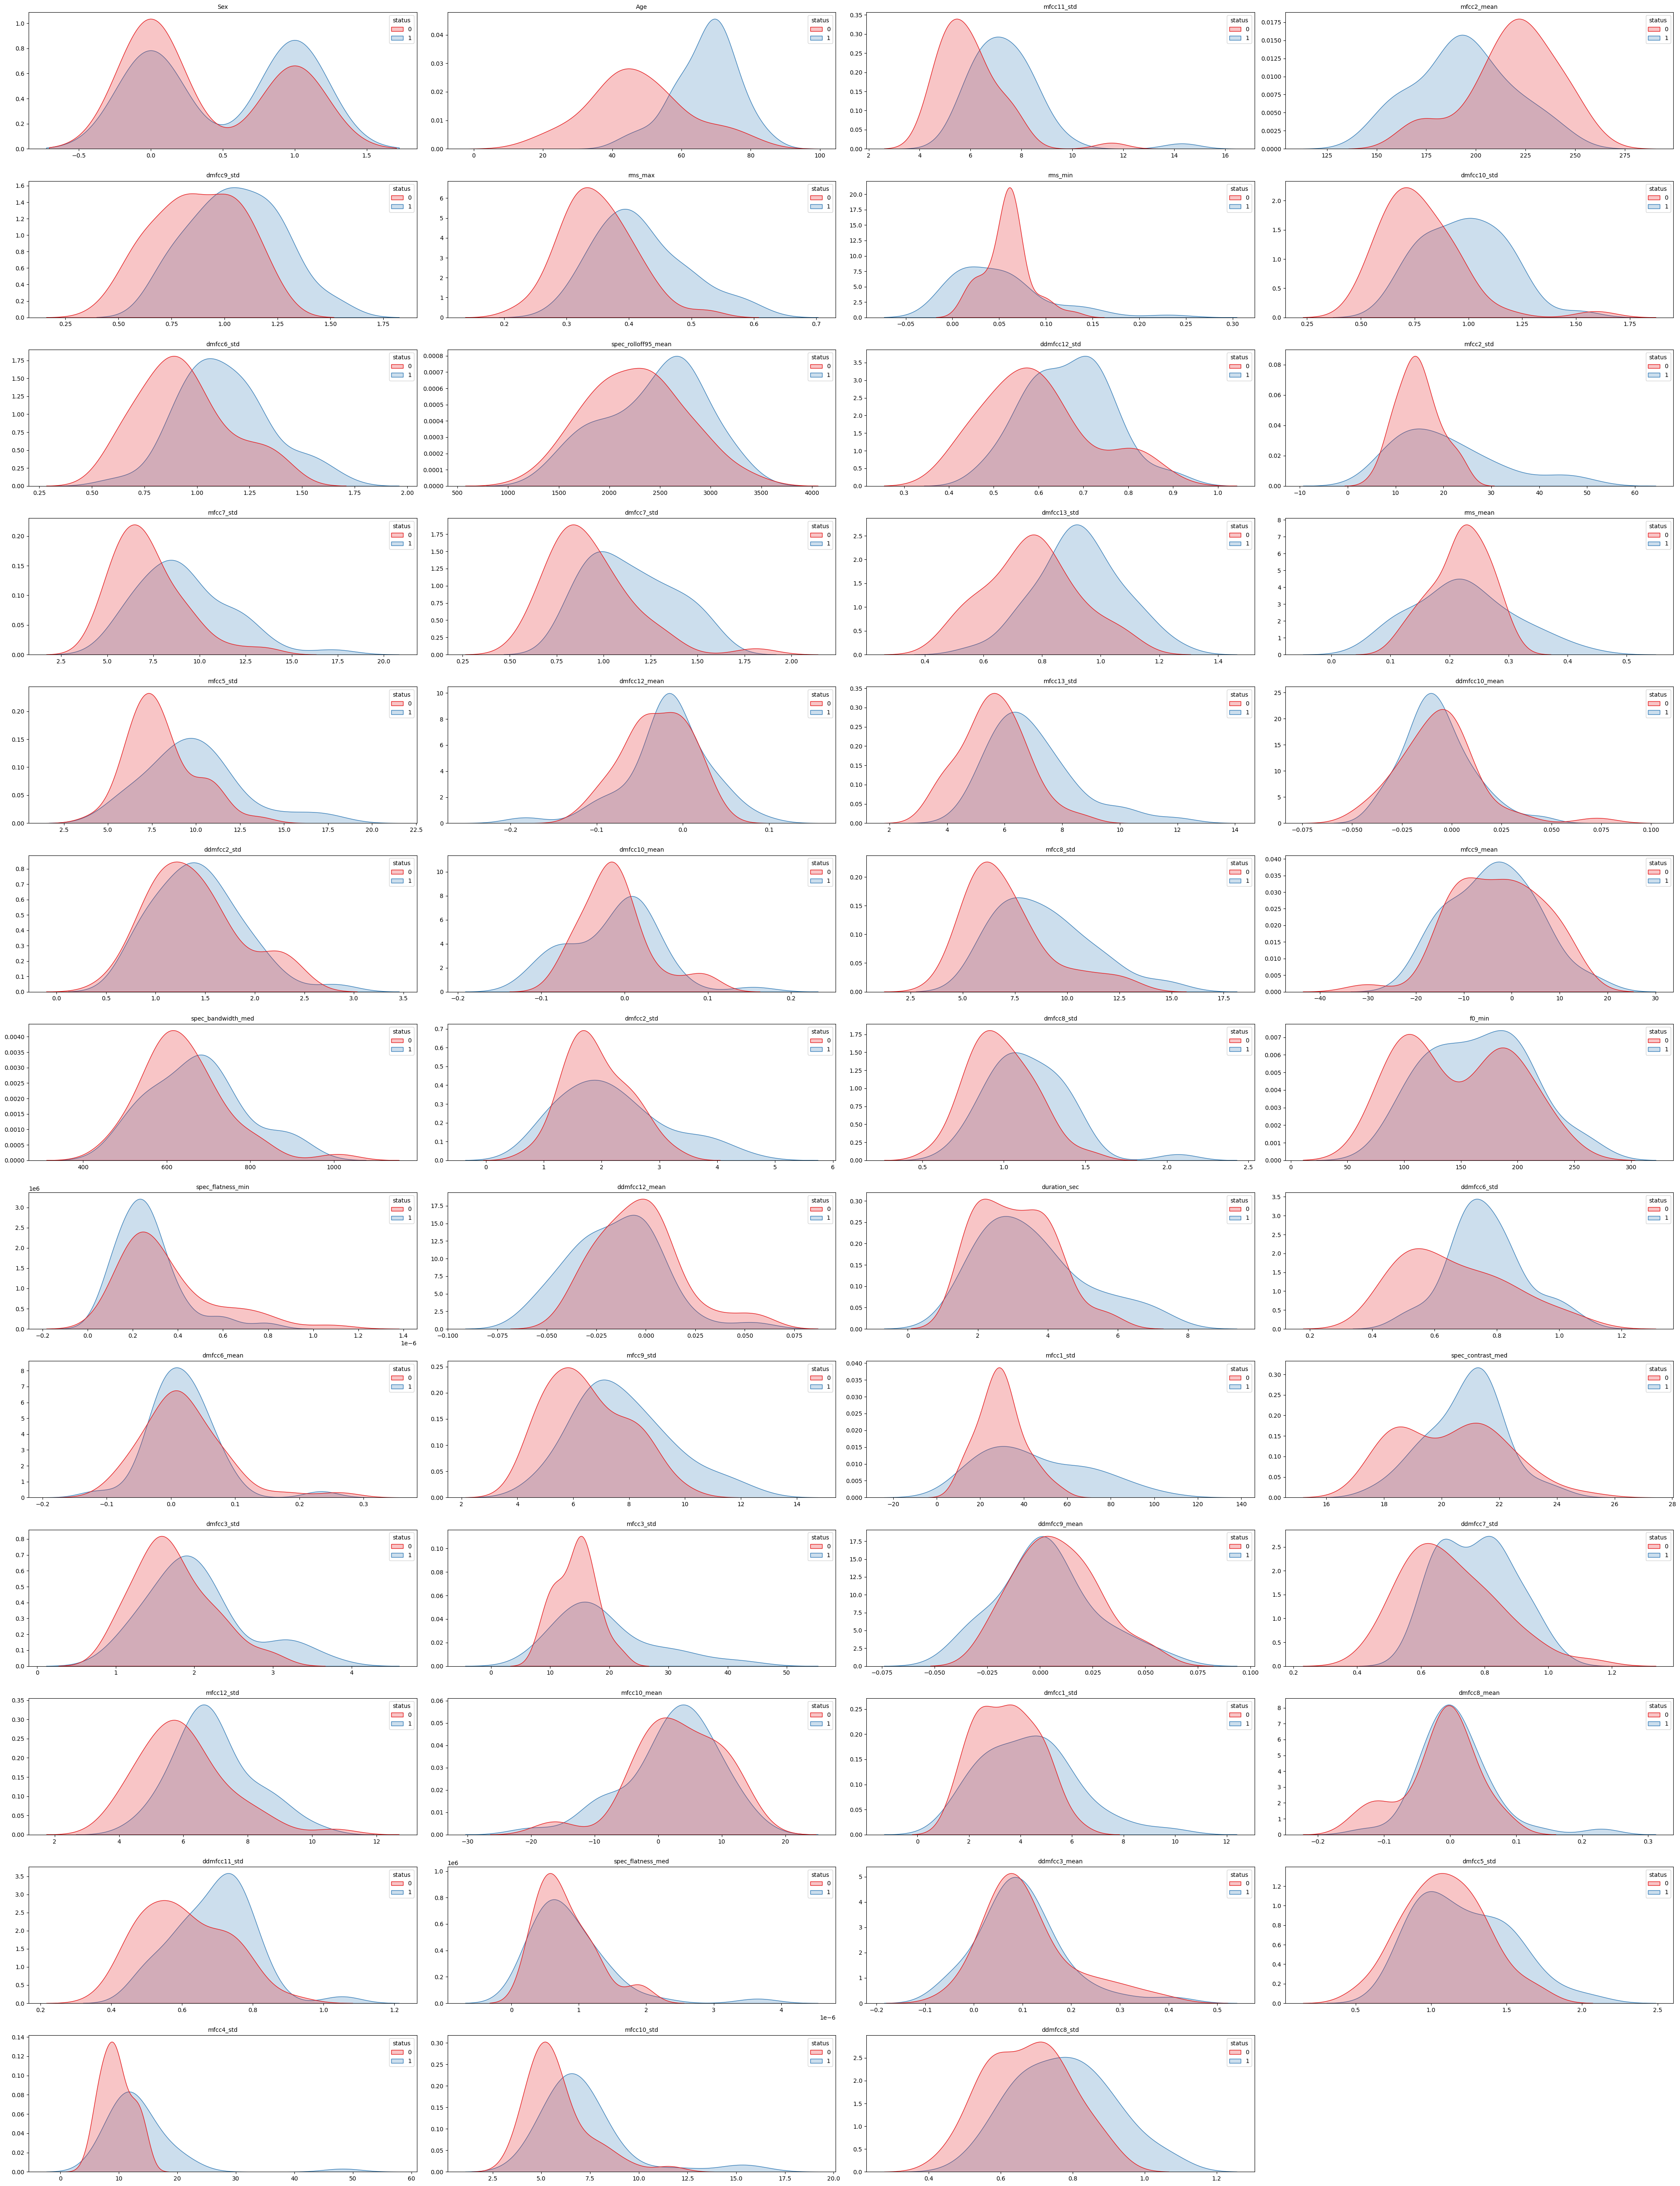

In [22]:

n_features = len(feature_cols)


n_rows = math.ceil(n_features / 4)

plt.figure(figsize=(40, 4 * n_rows))

for i, f in enumerate(feature_cols, 1):
    plt.subplot(n_rows, 4, i)
    sns.kdeplot(data=data, x=f, hue="status", fill=True, common_norm=False, palette="Set1")
    plt.title(f, fontsize=10)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


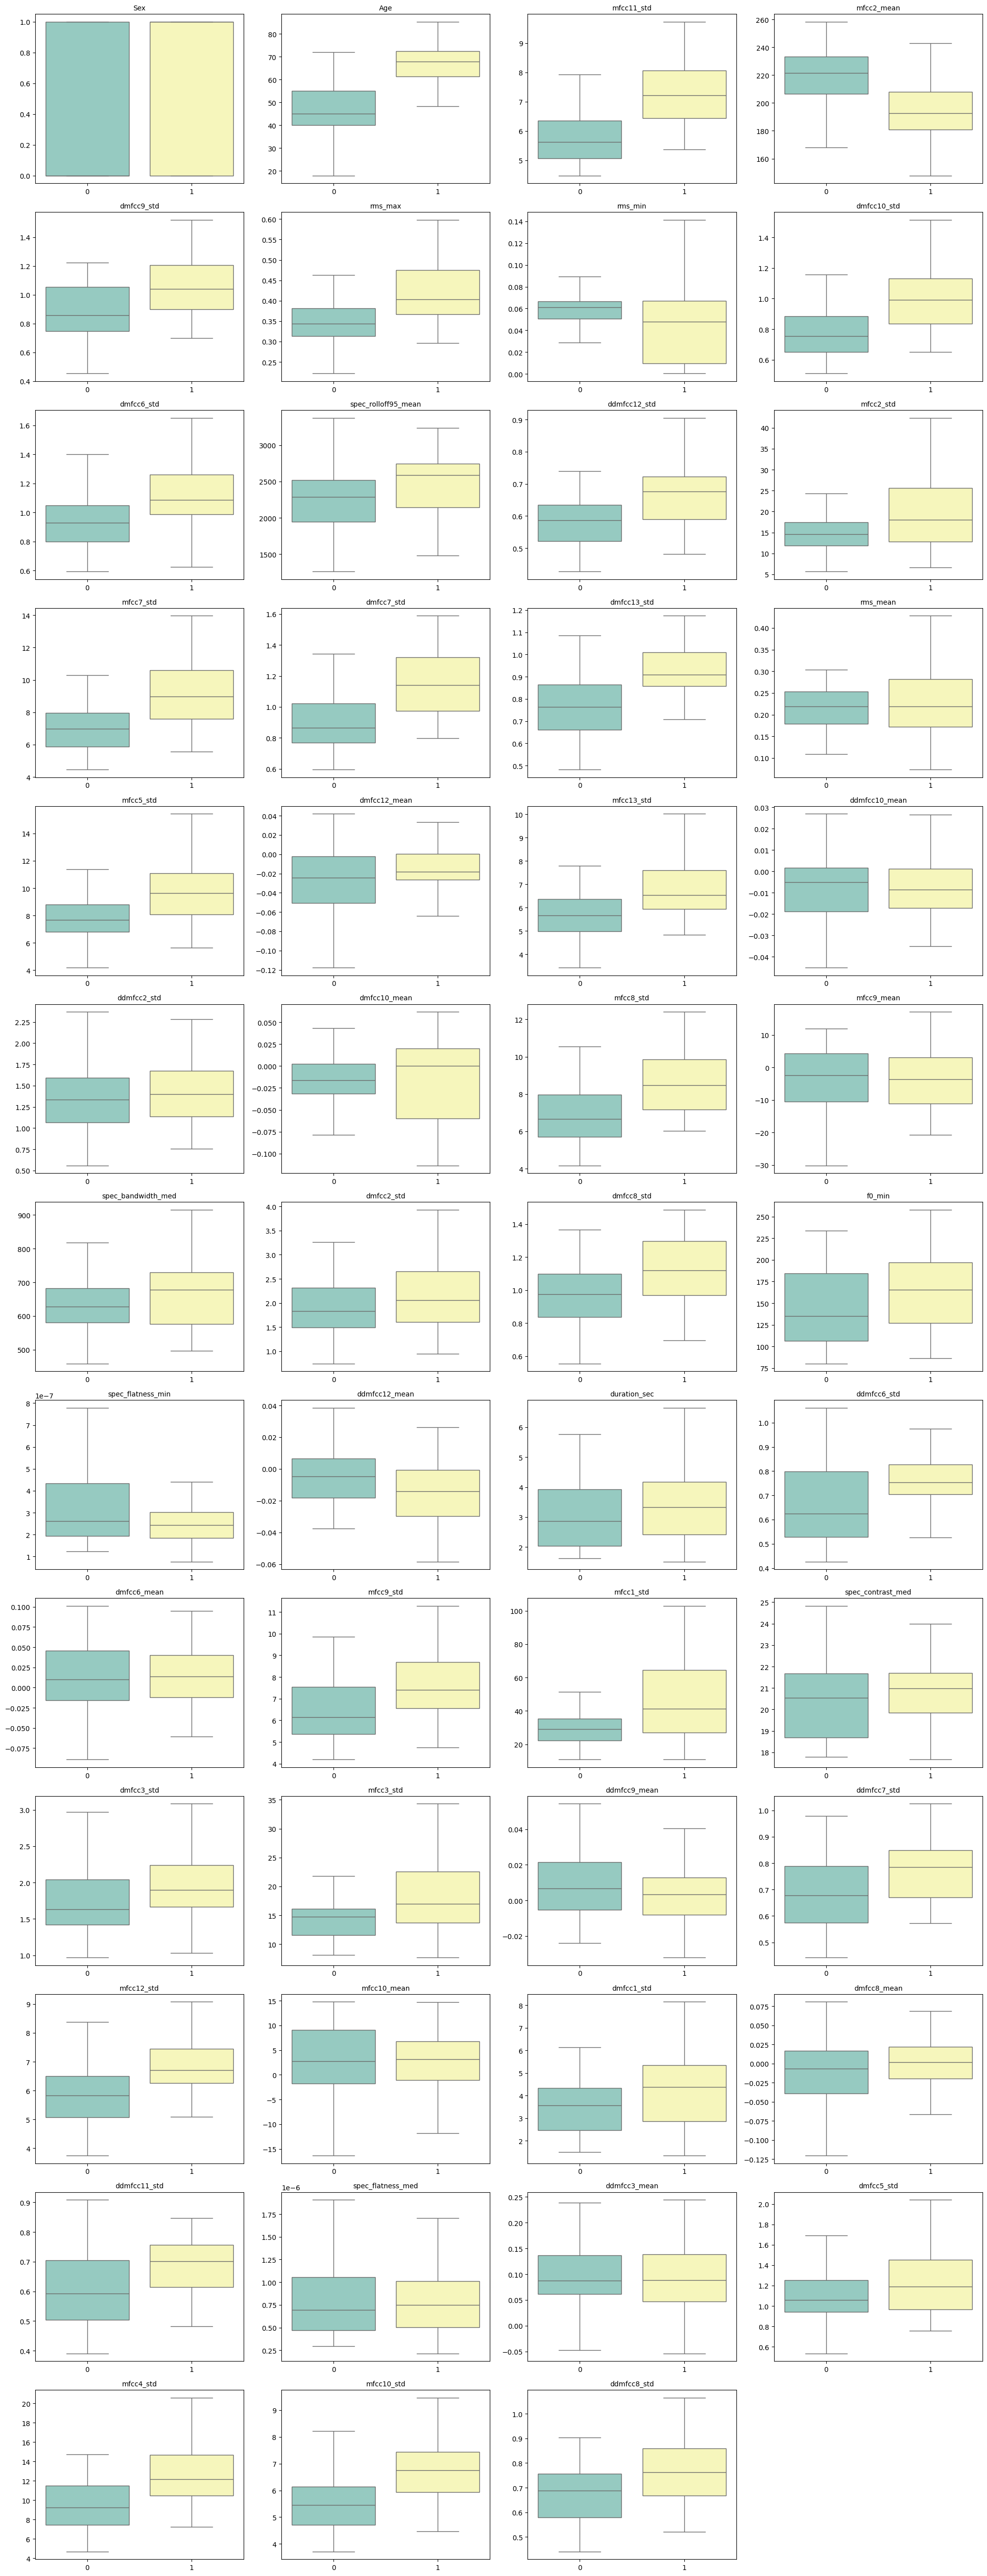

In [23]:

n_features = len(feature_cols)


n_rows = math.ceil(n_features / 4)

plt.figure(figsize=(20, 4 * n_rows))

for i, f in enumerate(feature_cols, 1):
    plt.subplot(n_rows, 4, i)
    sns.boxplot(x="status", y=f, data=data, palette="Set3", showfliers=False)
    plt.title(f, fontsize=10)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


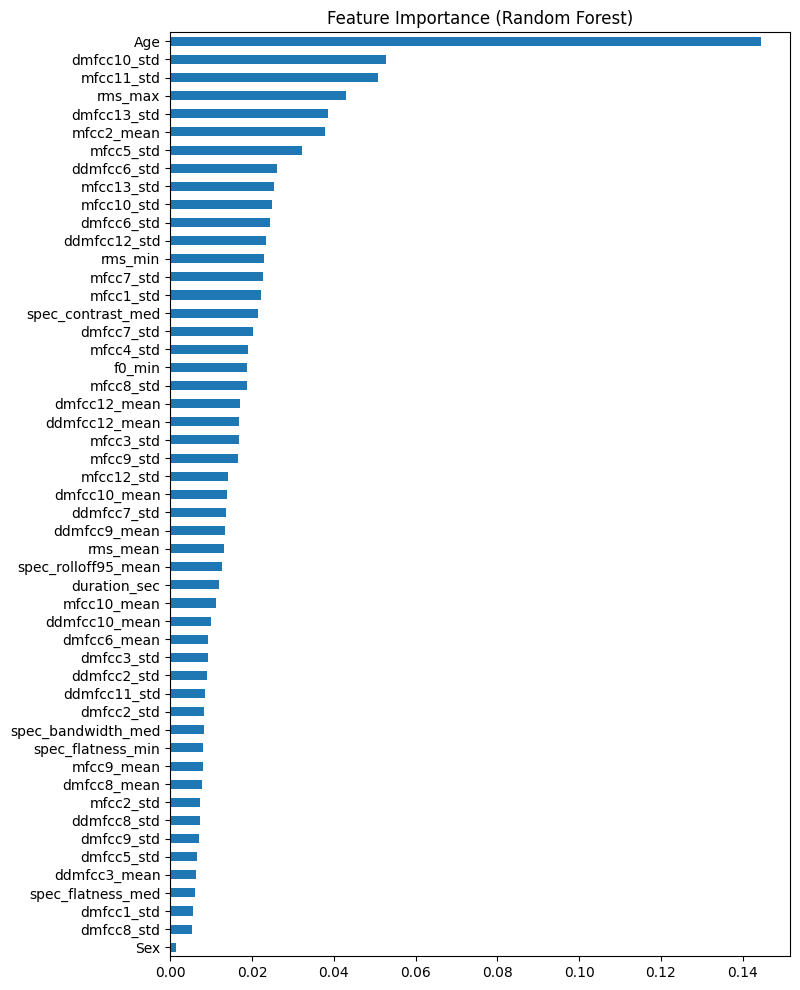

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(data[feature_cols], data["status"])
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(8, 12))
importances.plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.show()


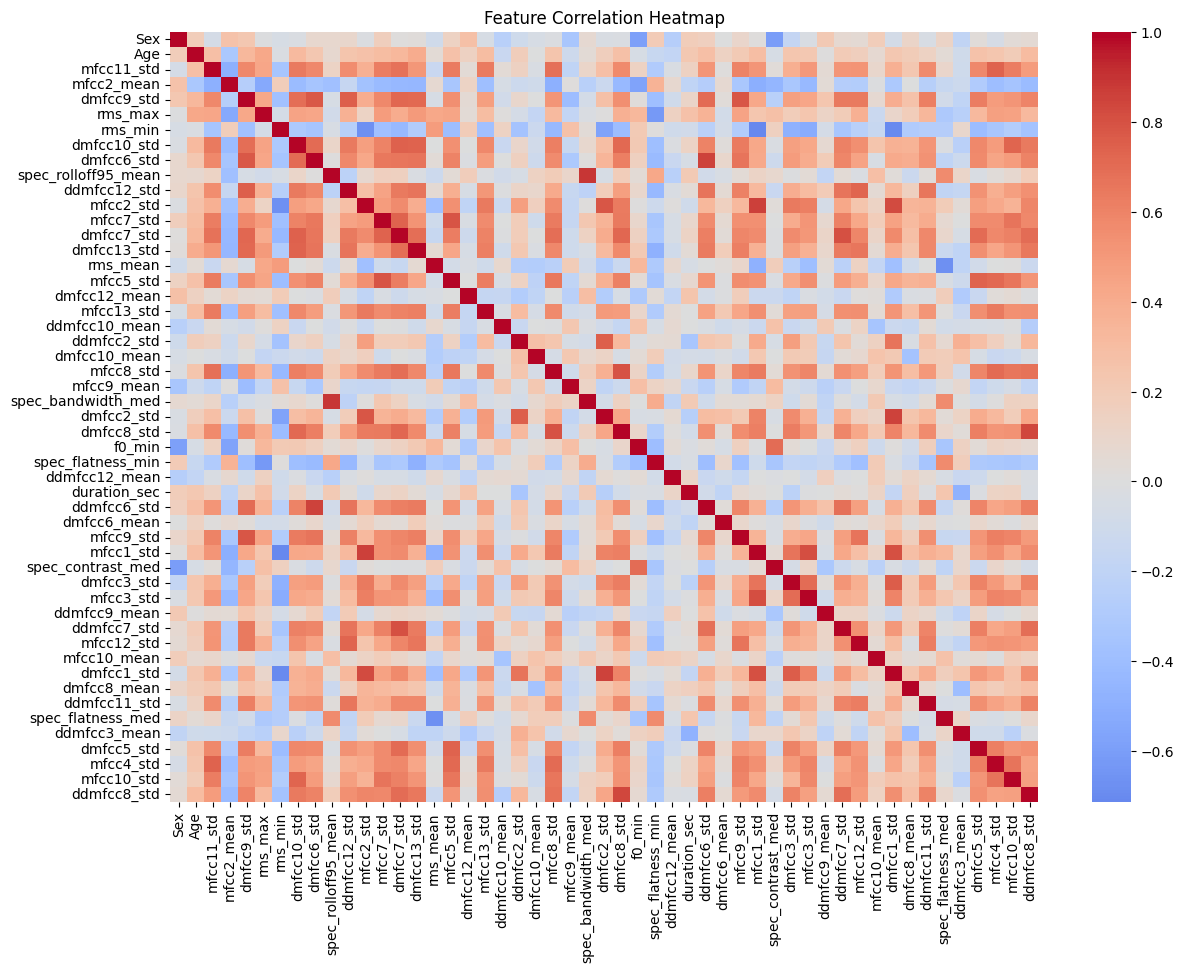

In [25]:
# === 4) Correlation Heatmap ===
plt.figure(figsize=(14,10))
sns.heatmap(data[feature_cols].corr(numeric_only=True), cmap="coolwarm", center=0, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

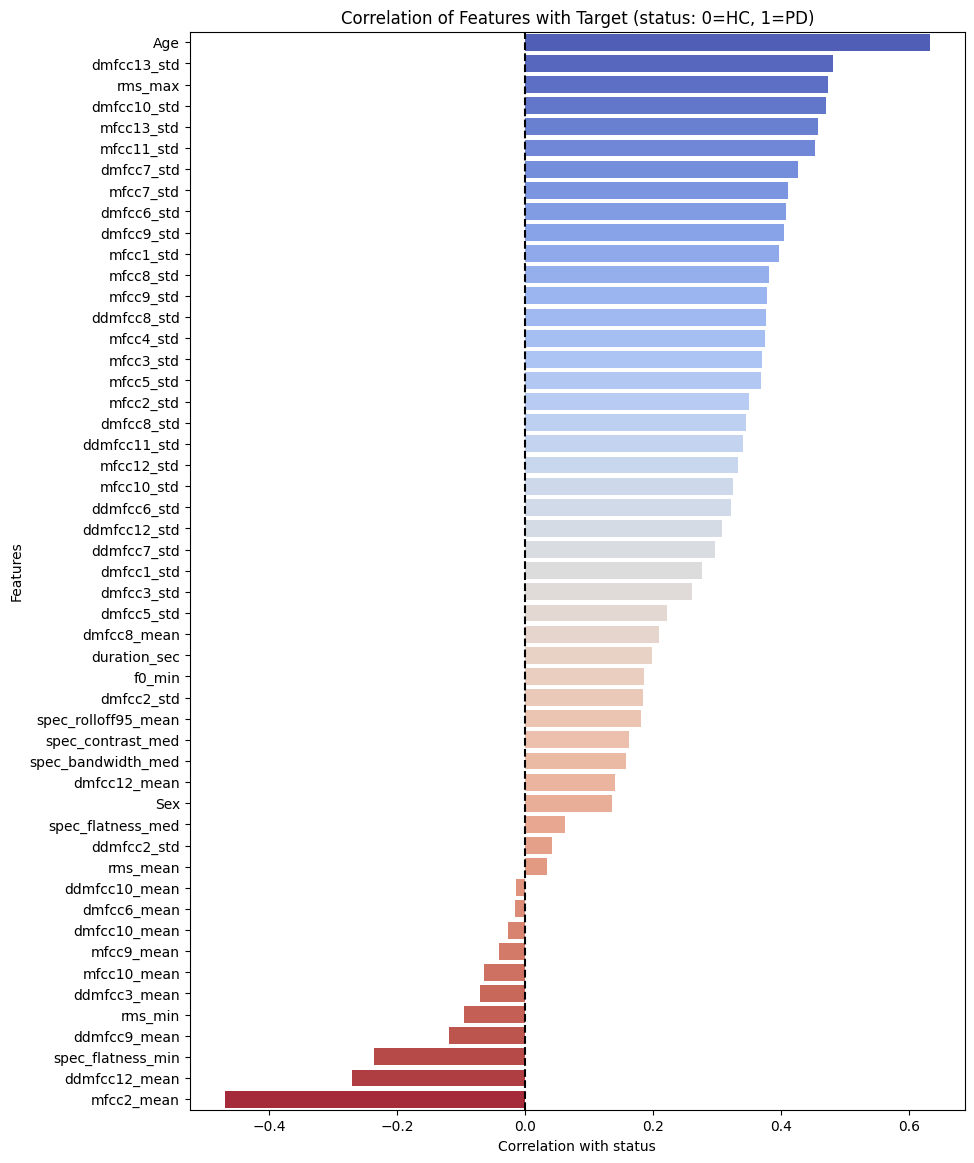

In [26]:
# orrelation of each feature with the target
corr_with_target = data[feature_cols + ["status"]].corr(numeric_only=True)["status"].drop("status")
corr_with_target = corr_with_target.sort_values(ascending=False)


plt.figure(figsize=(10, 14))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")
plt.title("Correlation of Features with Target (status: 0=HC, 1=PD)")
plt.xlabel("Correlation with status")
plt.ylabel("Features")
plt.axvline(0, color="black", linestyle="--")
plt.show()


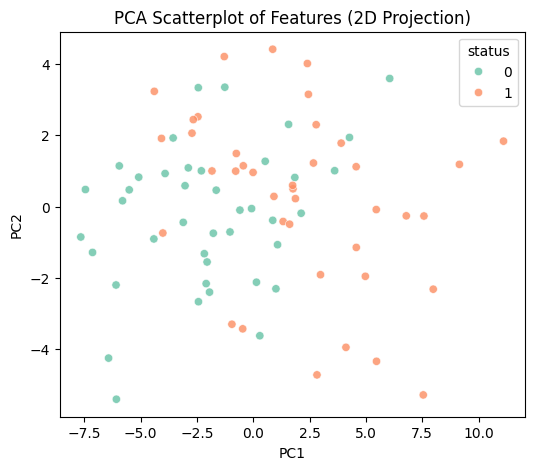

In [27]:

from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(data[feature_cols].fillna(0))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data["status"], palette="Set2", alpha=0.8)
plt.title("PCA Scatterplot of Features (2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Logistic Regression

Shapes -> Train: (56, 51), Test: (25, 51)

=== Logistic Regression — TRAIN ===
Accuracy: 0.839
ROC-AUC:  0.918
PR-AUC:   0.908
Confusion matrix:
 [[23  5]
 [ 4 24]]
              precision    recall  f1-score   support

           0      0.852     0.821     0.836        28
           1      0.828     0.857     0.842        28

    accuracy                          0.839        56
   macro avg      0.840     0.839     0.839        56
weighted avg      0.840     0.839     0.839        56


=== Logistic Regression — TEST ===
Accuracy: 0.840
ROC-AUC:  0.949
PR-AUC:   0.948
Confusion matrix:
 [[13  0]
 [ 4  8]]
              precision    recall  f1-score   support

           0      0.765     1.000     0.867        13
           1      1.000     0.667     0.800        12

    accuracy                          0.840        25
   macro avg      0.882     0.833     0.833        25
weighted avg      0.878     0.840     0.835        25



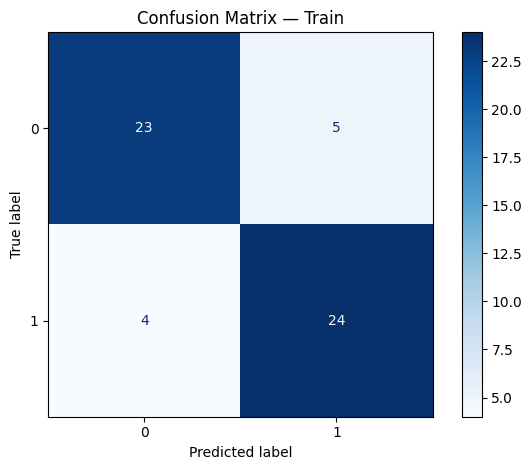

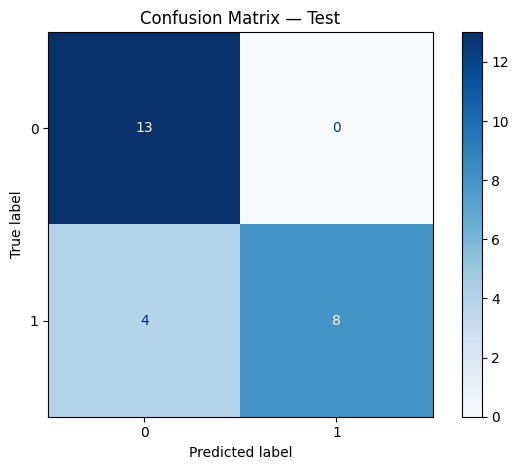

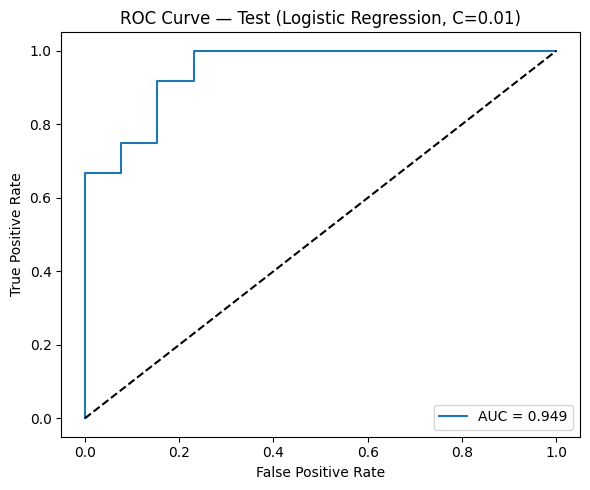

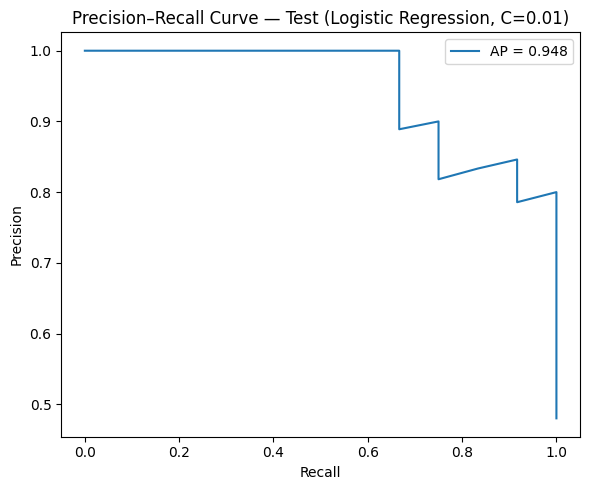

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)


META = ["name", "status"]
feature_cols = [c for c in data.columns if c not in META]

X = data[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(data[feature_cols].median())
y = data["status"].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print(f"Shapes -> Train: {X_train.shape}, Test: {X_test.shape}")


model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42,
        C=0.01
    ))
])


model.fit(X_train, y_train)


y_prob_train = model.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

print("\n=== Logistic Regression — TRAIN ===")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_train, y_prob_train):.3f}")
print(f"PR-AUC:   {average_precision_score(y_train, y_prob_train):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train, digits=3))


y_prob_test  = model.predict_proba(X_test)[:, 1]
y_pred_test  = (y_prob_test  >= 0.5).astype(int)

print("\n=== Logistic Regression — TEST ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_prob_test):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits=3))


labels = [str(c) for c in np.unique(y)]

cm_train = confusion_matrix(y_train, y_pred_train, labels=np.unique(y))
ConfusionMatrixDisplay(cm_train, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Train")
plt.tight_layout()
plt.show()


cm_test = confusion_matrix(y_test, y_pred_test, labels=np.unique(y))
ConfusionMatrixDisplay(cm_test, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Test")
plt.tight_layout()
plt.show()

# ==== Curves on TEST ====
# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_test):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test (Logistic Regression, C=0.01)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, y_prob_test):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Test (Logistic Regression, C=0.01)")
plt.legend()
plt.tight_layout()
plt.show()


# Random Forest Classifier


=== Random Forest — TRAIN ===
Accuracy: 0.875
ROC-AUC:  0.954
PR-AUC:   0.957
              precision    recall  f1-score   support

           0      0.889     0.857     0.873        28
           1      0.862     0.893     0.877        28

    accuracy                          0.875        56
   macro avg      0.875     0.875     0.875        56
weighted avg      0.875     0.875     0.875        56


=== Random Forest — TEST ===
Accuracy: 0.800
ROC-AUC:  0.923
PR-AUC:   0.918
              precision    recall  f1-score   support

           0      0.786     0.846     0.815        13
           1      0.818     0.750     0.783        12

    accuracy                          0.800        25
   macro avg      0.802     0.798     0.799        25
weighted avg      0.801     0.800     0.799        25



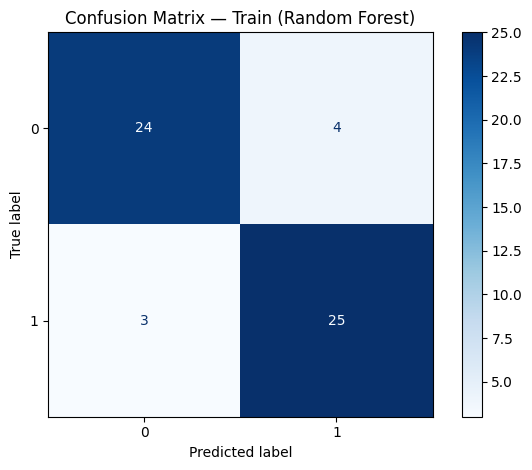

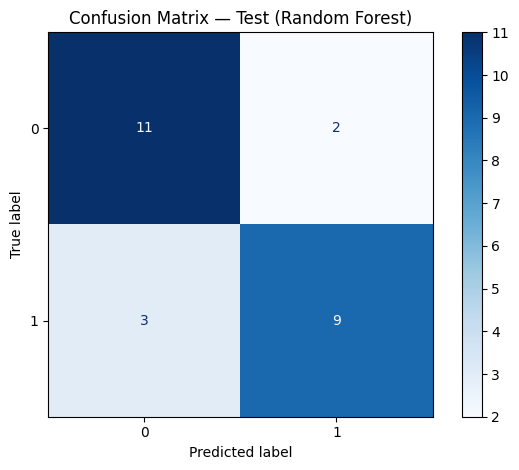

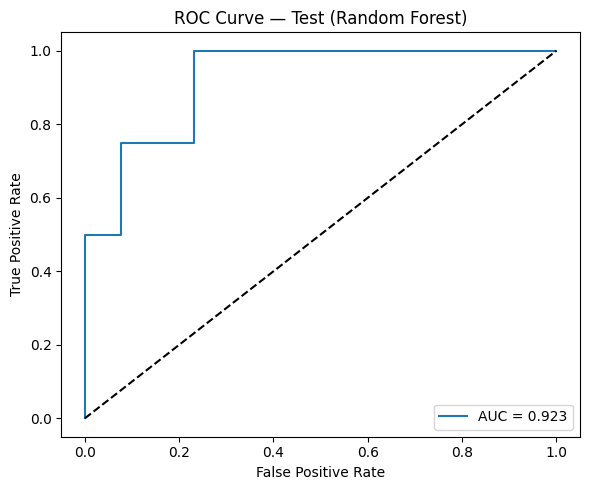

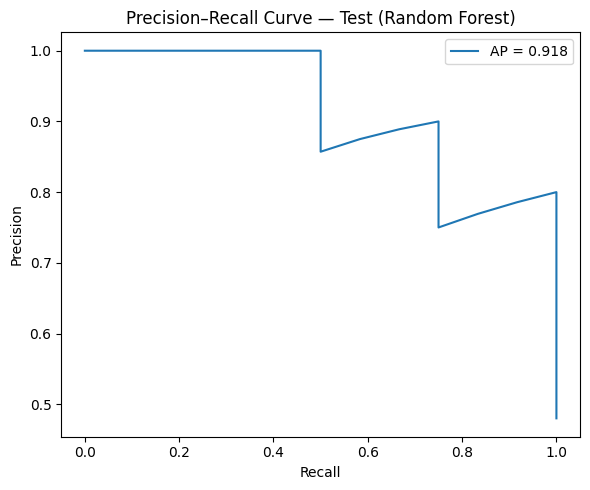

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay
)

# ====  Prepare X, y from your dataframe `data` ====
META = ["name", "status"]
feature_cols = [c for c in data.columns if c not in META]

X = data[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(data[feature_cols].median())
y = data["status"].astype(int)

# ==== Train / Test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# ==== Random Forest model (simple setup) ====
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=3,
    min_samples_leaf=15,
    min_samples_split=20,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ====  Evaluate ====
# Train
y_prob_train = rf.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

print("\n=== Random Forest — TRAIN ===")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_train, y_prob_train):.3f}")
print(f"PR-AUC:   {average_precision_score(y_train, y_prob_train):.3f}")
print(classification_report(y_train, y_pred_train, digits=3))

# Test
y_prob_test = rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n=== Random Forest — TEST ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_prob_test):.3f}")

print(classification_report(y_test, y_pred_test, digits=3))
labels = [str(c) for c in np.unique(y)]


cm_train = confusion_matrix(y_train, y_pred_train, labels=np.unique(y))
ConfusionMatrixDisplay(cm_train, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Train (Random Forest)")
plt.tight_layout()
plt.show()


cm_test = confusion_matrix(y_test, y_pred_test, labels=np.unique(y))
ConfusionMatrixDisplay(cm_test, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Test (Random Forest)")
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_test):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, y_prob_test):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Test (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()


# Support Vector Machine

X shape: (81, 51) | class counts: [41 40]

=== SVM (RBF) — TRAIN ===
Accuracy: 0.911
ROC-AUC:  0.982
PR-AUC:   0.982
              precision    recall  f1-score   support

           0      0.897     0.929     0.912        28
           1      0.926     0.893     0.909        28

    accuracy                          0.911        56
   macro avg      0.911     0.911     0.911        56
weighted avg      0.911     0.911     0.911        56


=== SVM (RBF) — TEST ===
Accuracy: 0.840
ROC-AUC:  0.878
PR-AUC:   0.898
              precision    recall  f1-score   support

           0      0.765     1.000     0.867        13
           1      1.000     0.667     0.800        12

    accuracy                          0.840        25
   macro avg      0.882     0.833     0.833        25
weighted avg      0.878     0.840     0.835        25



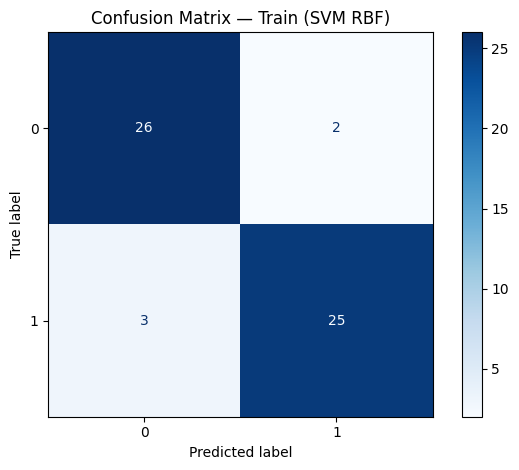

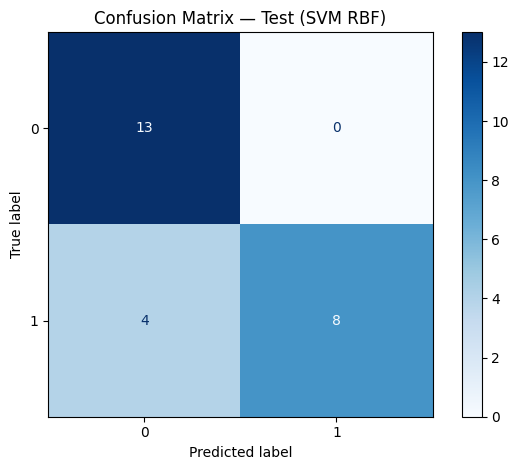

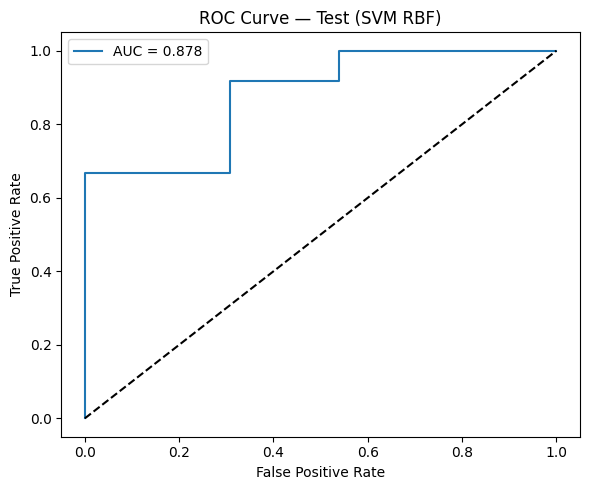

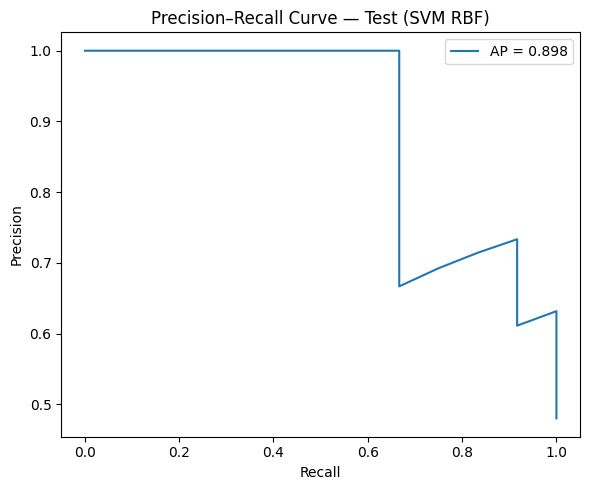

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay
)


META = ["name", "status"]
feature_cols = [c for c in data.columns if c not in META]

X = data[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(data[feature_cols].median())
y = data["status"].astype(int)

print("X shape:", X.shape, "| class counts:", np.bincount(y))

# ====  Train / Test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)


svm_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svc", SVC(
        kernel="rbf",
        C=1,
        gamma=0.01,
        probability=True,
        random_state=42
    ))
])

# ==== Fit and evaluate ====
svm_model.fit(X_train, y_train)

# TRAIN metrics
y_prob_train = svm_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

print("\n=== SVM (RBF) — TRAIN ===")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_train, y_prob_train):.3f}")
print(f"PR-AUC:   {average_precision_score(y_train, y_prob_train):.3f}")
print(classification_report(y_train, y_pred_train, digits=3))

# TEST metrics
y_prob_test = svm_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n=== SVM (RBF) — TEST ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_prob_test):.3f}")
print(classification_report(y_test, y_pred_test, digits=3))


labels = [str(c) for c in np.unique(y)]

# TRAIN CM
cm_train = confusion_matrix(y_train, y_pred_train, labels=np.unique(y))
ConfusionMatrixDisplay(cm_train, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Train (SVM RBF)")
plt.tight_layout()
plt.show()

# TEST CM
cm_test = confusion_matrix(y_test, y_pred_test, labels=np.unique(y))
ConfusionMatrixDisplay(cm_test, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Test (SVM RBF)")
plt.tight_layout()
plt.show()

# ==== Curves on TEST ====
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_test):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test (SVM RBF)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, y_prob_test):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Test (SVM RBF)")
plt.legend()
plt.tight_layout()
plt.show()


# TabPFN(v2)

In [31]:
 !pip install tabpfn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.7/173.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


[INFO] Using TabPFNClassifier
X shape: (81, 51) | class counts: [41 40]


tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]


=== TabPFN — TRAIN ===
Accuracy: 1.000
ROC-AUC:  1.000
PR-AUC:   1.000
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     1.000     1.000        28

    accuracy                          1.000        56
   macro avg      1.000     1.000     1.000        56
weighted avg      1.000     1.000     1.000        56


=== TabPFN — TEST ===
Accuracy: 0.840
ROC-AUC:  0.923
PR-AUC:   0.915
              precision    recall  f1-score   support

           0      0.800     0.923     0.857        13
           1      0.900     0.750     0.818        12

    accuracy                          0.840        25
   macro avg      0.850     0.837     0.838        25
weighted avg      0.848     0.840     0.838        25



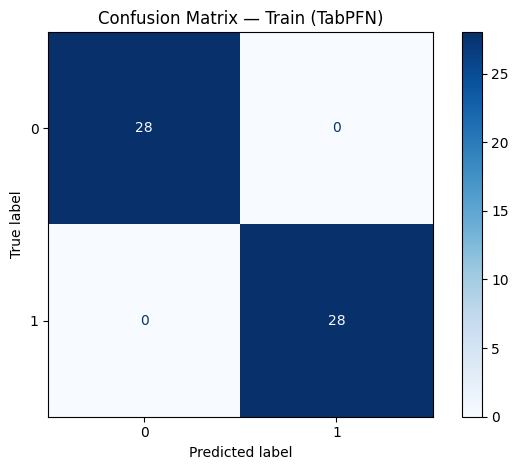

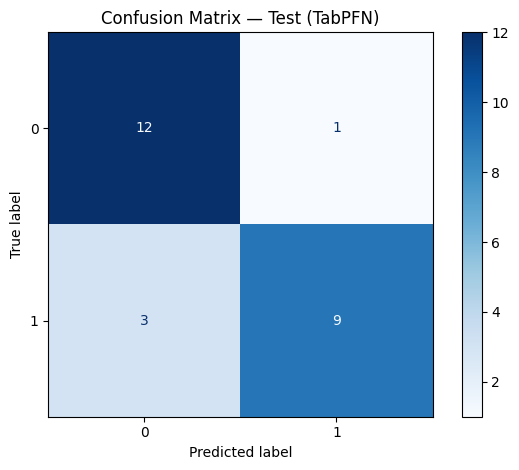

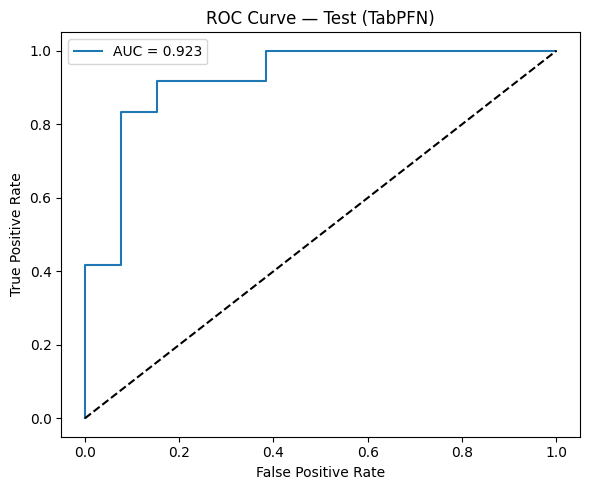

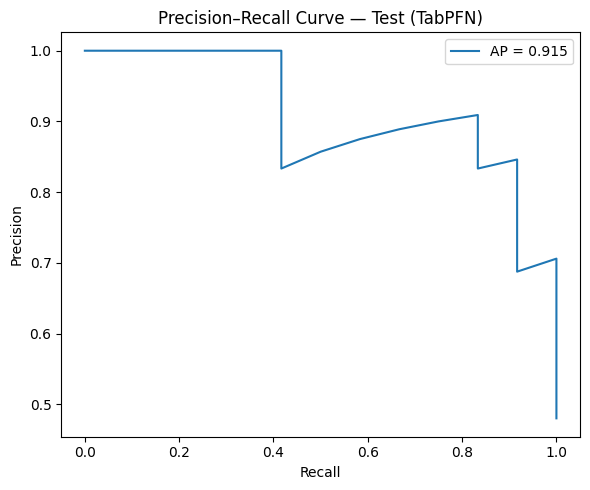

In [32]:
try:
    from tabpfn import TabPFNClassifierV2 as TabPFNCls
    TABPFN_NAME = "TabPFNClassifierV2"
except Exception:
    from tabpfn import TabPFNClassifier as TabPFNCls
    TABPFN_NAME = "TabPFNClassifier"

RANDOM_STATE = 42

META = ["name", "status"]
assert "status" in data.columns, "Target column 'status' not found."

feature_cols = [c for c in data.columns if c not in META]
X_all = data[feature_cols].apply(pd.to_numeric, errors="coerce")
y_all = data["status"].astype(int).values

print(f"[INFO] Using {TABPFN_NAME}")
print("X shape:", X_all.shape, "| class counts:", np.bincount(y_all))

# ====  Train / Test split (before any imputation) ====
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.30, stratify=y_all, random_state=RANDOM_STATE
)


train_median = X_train_df.median(numeric_only=True)
X_train_df = X_train_df.fillna(train_median)
X_test_df  = X_test_df.fillna(train_median)


keep_cols = X_train_df.columns[X_train_df.nunique(dropna=False) > 1]
X_train_df = X_train_df[keep_cols]
X_test_df  = X_test_df[keep_cols]

X_train = X_train_df.values.astype(np.float32)
X_test  = X_test_df.values.astype(np.float32)

# ====  Define a simple TabPFN model ====

tabpfn_model = TabPFNCls(
    n_estimators=4,
    random_state=RANDOM_STATE
)

# ==== Fit and evaluate ====
tabpfn_model.fit(X_train, y_train)

# TRAIN metrics (use 0.5 threshold to match your SVM example)
y_prob_train = tabpfn_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

print("\n=== TabPFN — TRAIN ===")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_train, y_prob_train):.3f}")
print(f"PR-AUC:   {average_precision_score(y_train, y_prob_train):.3f}")
print(classification_report(y_train, y_pred_train, digits=3))

# TEST metrics
y_prob_test = tabpfn_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n=== TabPFN — TEST ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_prob_test):.3f}")
print(classification_report(y_test, y_pred_test, digits=3))

labels = [str(c) for c in np.unique(y_all)]

# TRAIN CM
cm_train = confusion_matrix(y_train, y_pred_train, labels=np.unique(y_all))
ConfusionMatrixDisplay(cm_train, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Train (TabPFN)")
plt.tight_layout()
plt.show()

# TEST CM
cm_test = confusion_matrix(y_test, y_pred_test, labels=np.unique(y_all))
ConfusionMatrixDisplay(cm_test, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Test (TabPFN)")
plt.tight_layout()
plt.show()


# ==== Curves on TEST ====
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_test):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test (TabPFN)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, y_prob_test):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Test (TabPFN)")
plt.legend()
plt.tight_layout()
plt.show()


# Hypertab

In [33]:
pip install hypertab

X shape: (81, 51) | class counts: [41 40]

=== HyperTab — TRAIN ===
Accuracy: 0.464
ROC-AUC:  0.421
PR-AUC:   0.467
              precision    recall  f1-score   support

           0      0.475     0.679     0.559        28
           1      0.438     0.250     0.318        28

    accuracy                          0.464        56
   macro avg      0.456     0.464     0.439        56
weighted avg      0.456     0.464     0.439        56


=== HyperTab — TEST ===
Accuracy: 0.480
ROC-AUC:  0.282
PR-AUC:   0.389
              precision    recall  f1-score   support

           0      0.500     0.692     0.581        13
           1      0.429     0.250     0.316        12

    accuracy                          0.480        25
   macro avg      0.464     0.471     0.448        25
weighted avg      0.466     0.480     0.454        25



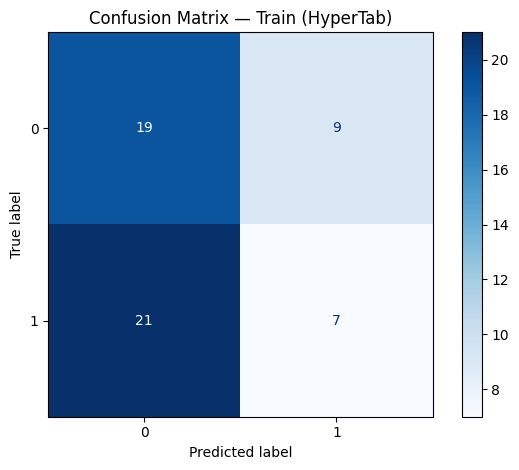

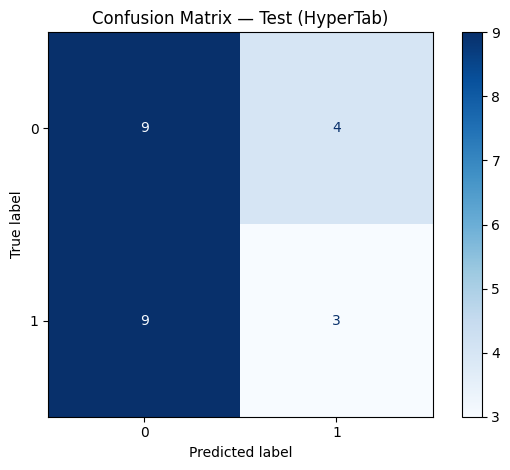

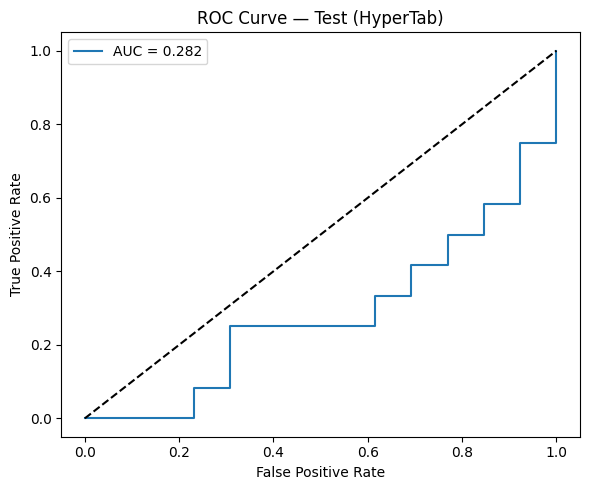

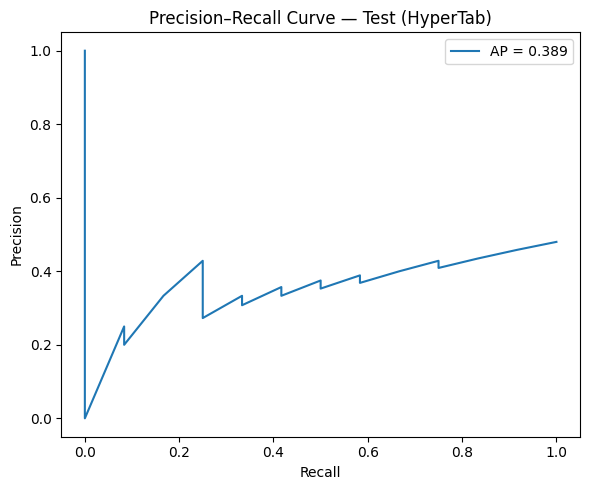

In [34]:
import inspect, torch, random
from hypertab import HyperTabClassifier

SEED = 42
random.seed(SEED); np.random.seed(SEED)
try:
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
except Exception:
    pass


META = ["name", "status"]
assert "status" in data.columns, "Target column 'status' not found."

feature_cols = [c for c in data.columns if c not in META]
X_all = data[feature_cols].apply(pd.to_numeric, errors="coerce")
y_all = data["status"].astype(int).values

print("X shape:", X_all.shape, "| class counts:", np.bincount(y_all))


X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.30, stratify=y_all, random_state=SEED
)


train_median = X_train_df.median(numeric_only=True)
X_train_df = X_train_df.fillna(train_median)
X_test_df  = X_test_df.fillna(train_median)

keep_cols = X_train_df.columns[X_train_df.nunique(dropna=False) > 1]
X_train_df = X_train_df[keep_cols]
X_test_df  = X_test_df[keep_cols]

X_train = X_train_df.values.astype(np.float32)
X_test  = X_test_df.values.astype(np.float32)


def make_hypertab(**cfg):
    """Pass only kwargs supported by your installed HyperTabClassifier."""
    allowed = set(inspect.signature(HyperTabClassifier.__init__).parameters.keys())
    filtered = {k: v for k, v in cfg.items() if k in allowed and v is not None}
    return HyperTabClassifier(**filtered)

device = "cuda:0" if torch.cuda.is_available() else "cpu"


ht_model = make_hypertab(
    subsample=0.5,
    test_nodes=200,
    epochs=15,
    hidden_dims=16,
    device=device,
    seed=SEED,
    random_state=SEED
)

# ==== 4) Fit and evaluate ====
ht_model.fit(X_train, y_train)

# TRAIN metrics
y_prob_train = ht_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

print("\n=== HyperTab — TRAIN ===")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_train, y_prob_train):.3f}")
print(f"PR-AUC:   {average_precision_score(y_train, y_prob_train):.3f}")
print(classification_report(y_train, y_pred_train, digits=3))

# TEST
y_prob_test = ht_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n=== HyperTab — TEST ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"PR-AUC:   {average_precision_score(y_test, y_prob_test):.3f}")
print(classification_report(y_test, y_pred_test, digits=3))
labels = [str(c) for c in np.unique(y_all)]

# TRAIN CM
cm_train = confusion_matrix(y_train, y_pred_train, labels=np.unique(y_all))
ConfusionMatrixDisplay(cm_train, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Train (HyperTab)")
plt.tight_layout()
plt.show()

# TEST CM
cm_test = confusion_matrix(y_test, y_pred_test, labels=np.unique(y_all))
ConfusionMatrixDisplay(cm_test, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Test (HyperTab)")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_test):.3f}")
plt.plot([0,1], [0,1], 'k--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test (HyperTab)"); plt.legend(); plt.tight_layout(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, y_prob_test):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Test (HyperTab)")
plt.legend(); plt.tight_layout(); plt.show()


# TABNET

In [35]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.6 MB/s eta 0:00:00


Shape: (81, 51) | class counts: [41 40]

Early stopping occurred at epoch 186 with best_epoch = 106 and best_val_auc = 0.86111

Early stopping occurred at epoch 185 with best_epoch = 105 and best_train_auc = 0.82398

=== TabNet — TRAIN (refit; threshold from VAL) ===
Accuracy: 0.696
ROC-AUC:  0.824
PR-AUC:   0.848
              precision    recall  f1-score   support

           0      0.789     0.536     0.638        28
           1      0.649     0.857     0.738        28

    accuracy                          0.696        56
   macro avg      0.719     0.696     0.688        56
weighted avg      0.719     0.696     0.688        56


=== TabNet — TEST ===
Accuracy: 0.760
ROC-AUC:  0.853
PR-AUC:   0.839
              precision    recall  f1-score   support

           0      0.818     0.692     0.750        13
           1      0.714     0.833     0.769        12

    accuracy                          0.760        25
   macro avg      0.766     0.763     0.760        25
weighted avg  

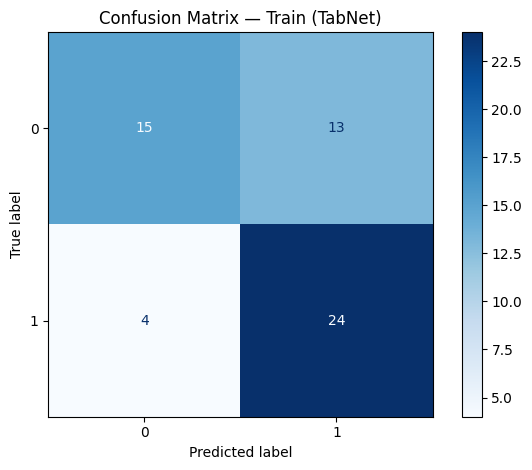

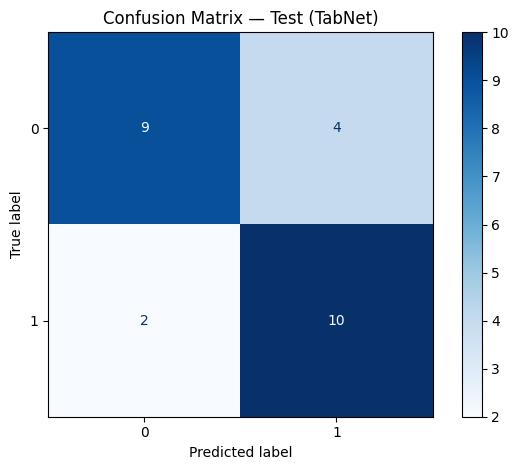

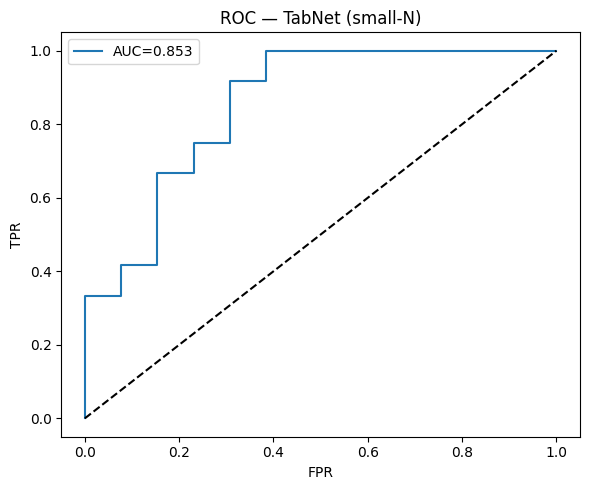

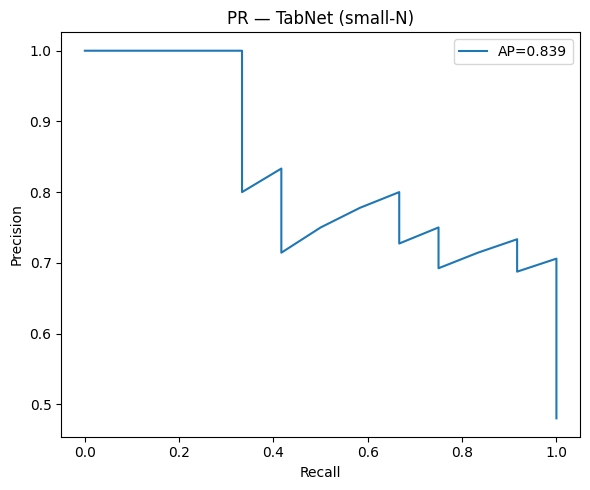

In [36]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.feature_selection import mutual_info_classif
from pytorch_tabnet.tab_model import TabNetClassifier

SEED = 42
META = ["name","status"]

assert "status" in data.columns
feat = [c for c in data.columns if c not in META]
X_all = data[feat].apply(pd.to_numeric, errors="coerce")
y_all = data["status"].astype(int).values
print("Shape:", X_all.shape, "| class counts:", np.bincount(y_all))
X_tr_df, X_te_df, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.30, stratify=y_all, random_state=SEED)
med = X_tr_df.median(numeric_only=True)
X_tr_df = X_tr_df.fillna(med); X_te_df = X_te_df.fillna(med)
keep = X_tr_df.columns[X_tr_df.nunique(dropna=False) > 1]
X_tr_df = X_tr_df[keep]; X_te_df = X_te_df[keep]


X_tr_in_df, X_val_df, y_tr_in, y_val = train_test_split(X_tr_df, y_tr, test_size=0.20, stratify=y_tr, random_state=SEED)
K = min(20, X_tr_in_df.shape[1])
mi = mutual_info_classif(X_tr_in_df.values, y_tr_in, random_state=SEED)
rank = pd.Series(mi, index=X_tr_in_df.columns).sort_values(ascending=False)
topk = rank.index[:K].tolist()
X_tr_in = X_tr_in_df[topk].values.astype(np.float32)
X_val   = X_val_df[topk].values.astype(np.float32)
X_tr    = X_tr_df[topk].values.astype(np.float32)
X_te    = X_te_df[topk].values.astype(np.float32)


device_name = "cuda" if torch.cuda.is_available() else "cpu"
tabnet = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.5,
    n_independent=1, n_shared=1,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=3e-4, weight_decay=2e-4),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=50, gamma=0.9),
    mask_type="entmax",
    verbose=0,
    device_name=device_name,
    seed=SEED
)


tabnet.fit(
    X_tr_in, y_tr_in,
    eval_set=[(X_val, y_val)],
    eval_name=["val"],
    eval_metric=["auc"],
    max_epochs=1000,
    patience=80,
    batch_size=32,
    virtual_batch_size=16
)

def best_thresh_by_f1(y_true, y_prob):
    pr, rc, th = precision_recall_curve(y_true, y_prob)
    cand = np.r_[0.0, th, 1.0]
    f1s  = [f1_score(y_true, (y_prob>=t).astype(int), zero_division=0) for t in cand]
    return float(cand[int(np.argmax(f1s))])

p_val = tabnet.predict_proba(X_val)[:,1]
th = best_thresh_by_f1(y_val, p_val)


tabnet.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr)],
    eval_name=["train"],
    eval_metric=["auc"],
    max_epochs=tabnet.max_epochs,
    patience=tabnet.patience,
    batch_size=32,
    virtual_batch_size=16
)


p_tr = tabnet.predict_proba(X_tr)[:,1]; yhat_tr = (p_tr >= th).astype(int)
print("\n=== TabNet — TRAIN (refit; threshold from VAL) ===")
print(f"Accuracy: {accuracy_score(y_tr, yhat_tr):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_tr, p_tr):.3f}")
print(f"PR-AUC:   {average_precision_score(y_tr, p_tr):.3f}")
print(classification_report(y_tr, yhat_tr, digits=3))

p_te = tabnet.predict_proba(X_te)[:,1]; yhat_te = (p_te >= th).astype(int)
print("\n=== TabNet — TEST ===")
print(f"Accuracy: {accuracy_score(y_te, yhat_te):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_te, p_te):.3f}")
print(f"PR-AUC:   {average_precision_score(y_te, p_te):.3f}")
print(classification_report(y_te, yhat_te, digits=3))



labels = [str(c) for c in np.unique(y_all)]
cm_tr = confusion_matrix(y_tr, yhat_tr, labels=np.unique(y_all))
ConfusionMatrixDisplay(cm_tr, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Train (TabNet)")
plt.tight_layout()
plt.show()


cm_te = confusion_matrix(y_te, yhat_te, labels=np.unique(y_all))
ConfusionMatrixDisplay(cm_te, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Test (TabNet)")
plt.tight_layout()
plt.show()


fpr,tpr,_ = roc_curve(y_te, p_te)
plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_te,p_te):.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — TabNet (small-N)"); plt.legend(); plt.tight_layout(); plt.show()

prec,rec,_ = precision_recall_curve(y_te,p_te)
plt.figure(figsize=(6,5)); plt.plot(rec,prec,label=f"AP={average_precision_score(y_te,p_te):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — TabNet (small-N)"); plt.legend(); plt.tight_layout(); plt.show()


# Saint Lite Model


X shape: (81, 51) | class counts: [41 40]

=== SAINT — TRAIN ===
Accuracy: 0.821
ROC-AUC:  0.946
PR-AUC:   0.921
              precision    recall  f1-score   support

           0      1.000     0.643     0.783        28
           1      0.737     1.000     0.848        28

    accuracy                          0.821        56
   macro avg      0.868     0.821     0.816        56
weighted avg      0.868     0.821     0.816        56


=== SAINT — TEST ===
Accuracy: 0.800
ROC-AUC:  0.801
PR-AUC:   0.780
              precision    recall  f1-score   support

           0      0.900     0.692     0.783        13
           1      0.733     0.917     0.815        12

    accuracy                          0.800        25
   macro avg      0.817     0.804     0.799        25
weighted avg      0.820     0.800     0.798        25



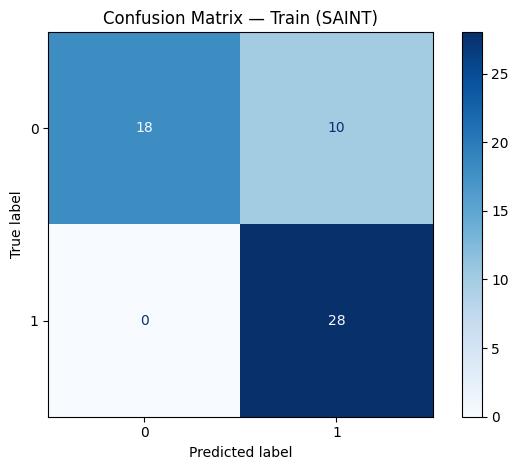

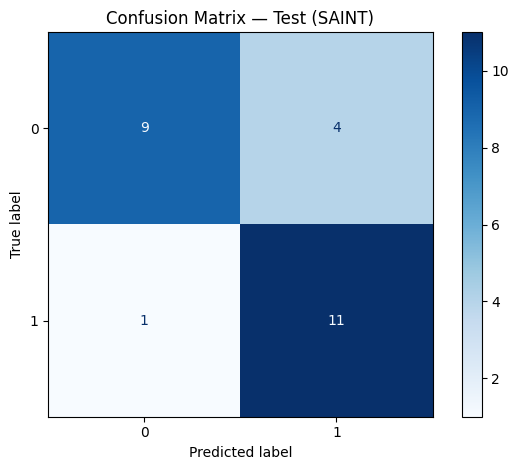

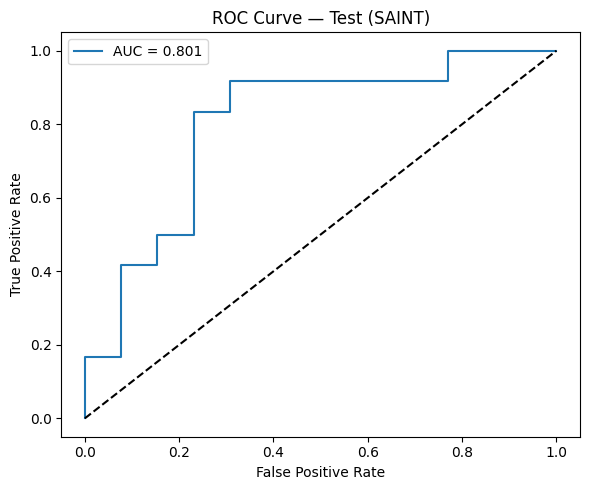

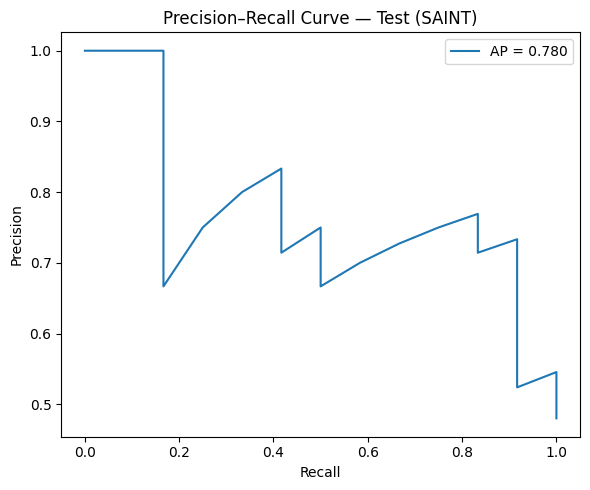

In [37]:
import torch.nn as nn
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


D_MODEL   = 24
N_HEADS   = 4
N_LAYERS  = 1
DROPOUT   = 0.30
TOK_DROPOUT = 0.30
EPOCHS    = 250
BATCHSIZE = 32
LR        = 6e-4
WEIGHT_DECAY = 1e-3


META = ["name","status"]
assert "status" in data.columns, "Target column 'status' is missing."

feature_cols = [c for c in data.columns if c not in META]
X_all = data[feature_cols].apply(pd.to_numeric, errors="coerce")
y_all = data["status"].astype(int).values

print("X shape:", X_all.shape, "| class counts:", np.bincount(y_all))


X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.30, stratify=y_all, random_state=SEED
)


med = X_train_df.median(numeric_only=True)
X_train_df = X_train_df.fillna(med)
X_test_df  = X_test_df.fillna(med)

keep = X_train_df.columns[X_train_df.nunique(dropna=False) > 1]
X_train_df = X_train_df[keep]
X_test_df  = X_test_df[keep]


scaler = StandardScaler().fit(X_train_df.values)
X_train = scaler.transform(X_train_df.values).astype(np.float32)
X_test  = scaler.transform(X_test_df.values).astype(np.float32)


class SAINTLite(nn.Module):
    """
    Each feature -> token: proj(value) + column embedding.
    Prepend a CLS token; pass through TransformerEncoder; classify from CLS.
    """
    def __init__(self, n_features, d_model=24, n_heads=4, n_layers=1, p_drop=0.30, p_tok=0.30):
        super().__init__()
        self.scalar_proj = nn.Linear(1, d_model)
        self.col_embed   = nn.Parameter(torch.randn(n_features, d_model) * 0.02)
        self.cls_token   = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        self.token_dropout = nn.Dropout(p_tok)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4,
            dropout=p_drop, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x):        # x: (B, F)
        B, F = x.shape
        tok = self.scalar_proj(x.view(B, F, 1)) + self.col_embed.unsqueeze(0)  # (B,F,d)
        tok = self.token_dropout(tok)
        seq = torch.cat([self.cls_token.expand(B, -1, -1), tok], dim=1)        # (B,1+F,d)
        enc = self.encoder(seq)                                                # (B,1+F,d)
        cls = self.norm(enc[:, 0, :])                                          # (B,d)
        return self.head(cls).squeeze(-1)                                      # (B,)

    def predict_proba(self, x):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid(self.forward(x))


n_features = X_train.shape[1]
model = SAINTLite(
    n_features=n_features,
    d_model=D_MODEL, n_heads=N_HEADS, n_layers=N_LAYERS,
    p_drop=DROPOUT, p_tok=TOK_DROPOUT
).to(device)

opt  = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit = nn.BCEWithLogitsLoss()

Xtr_t = torch.from_numpy(X_train).to(device)
ytr_t = torch.from_numpy(y_train.astype(np.float32)).to(device)


for _ in range(EPOCHS):
    model.train()
    idx = np.random.permutation(len(X_train))
    for i in range(0, len(idx), BATCHSIZE):
        j = idx[i:i+BATCHSIZE]
        xb = Xtr_t[j]; yb = ytr_t[j]
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()


def eval_block(X, y, title):
    Xt = torch.from_numpy(X).to(device)
    p  = model.predict_proba(Xt).cpu().numpy()
    yhat = (p >= 0.5).astype(int)
    print(f"\n=== SAINT — {title} ===")
    print(f"Accuracy: {accuracy_score(y, yhat):.3f}")
    print(f"ROC-AUC:  {roc_auc_score(y, p):.3f}")
    print(f"PR-AUC:   {average_precision_score(y, p):.3f}")
    print(classification_report(y, yhat, digits=3))
    return p

p_train = eval_block(X_train, y_train, "TRAIN")
p_test  = eval_block(X_test, y_test, "TEST")


labels = [str(c) for c in np.unique(np.r_[y_train, y_test])]

# TRAIN
cm_tr = confusion_matrix(y_train, (p_train >= 0.5).astype(int), labels=np.unique(np.r_[y_train, y_test]))
ConfusionMatrixDisplay(cm_tr, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Train (SAINT)")
plt.tight_layout()
plt.show()

# TEST
cm_te = confusion_matrix(y_test, (p_test >= 0.5).astype(int), labels=np.unique(np.r_[y_train, y_test]))
ConfusionMatrixDisplay(cm_te, display_labels=labels).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Test (SAINT)")
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_test, p_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, p_test):.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test (SAINT)"); plt.legend(); plt.tight_layout(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, p_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, p_test):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Test (SAINT)")
plt.legend(); plt.tight_layout(); plt.show()


# SVM Model

In [38]:

from joblib import dump
from datetime import datetime

svm_bundle = {
    "pipeline": svm_model,
    "feature_names": feature_cols,
    "threshold": 0.5,
    "created_at": datetime.utcnow().isoformat(timespec="seconds") + "Z"
}

dump(svm_bundle, "svm_pipeline.joblib")
print("Saved SVM pipeline -> svm_pipeline.joblib")


Saved SVM pipeline -> svm_pipeline.joblib


In [39]:
from joblib import load
import pandas as pd
import numpy as np

svm_bundle = load("svm_pipeline.joblib")
svm_pipe   = svm_bundle["pipeline"]
feat_order = svm_bundle["feature_names"]
thr        = svm_bundle["threshold"]

def svm_predict_proba(df: pd.DataFrame) -> np.ndarray:
    X = df[feat_order].apply(pd.to_numeric, errors="coerce")
    X = X.fillna(X.median(numeric_only=True))   # same simple median policy
    return svm_pipe.predict_proba(X)[:, 1]

def svm_predict(df: pd.DataFrame) -> np.ndarray:
    p = svm_predict_proba(df)
    return (p >= thr).astype(int)


# SAINT-lite Model

In [40]:
# ==== SAVE SAINT PREPROCESSING ====
from joblib import dump
from datetime import datetime


saint_preproc = {
    "medians": med.to_dict(),
    "keep_cols": list(keep),
    "feature_order": list(keep),
    "scaler": scaler,
    "threshold": 0.5,
    "class_names": ["0", "1"],
    "created_at": datetime.utcnow().isoformat(timespec="seconds") + "Z"
}
dump(saint_preproc, "saint_preproc.joblib")
print("Saved SAINT preprocessing -> saint_preproc.joblib")


import torch

saint_ckpt = {
    "state_dict": model.state_dict(),
    "model_config": {
        "n_features": n_features,
        "d_model": D_MODEL,
        "n_heads": N_HEADS,
        "n_layers": N_LAYERS,
        "p_drop": DROPOUT,
        "p_tok": TOK_DROPOUT
    }
}
torch.save(saint_ckpt, "saint_model.pt")
print("Saved SAINT weights -> saint_model.pt")


Saved SAINT preprocessing -> saint_preproc.joblib
Saved SAINT weights -> saint_model.pt


In [41]:
# ==== LOAD & PREDICT — SAINT ====
import torch, torch.nn as nn
import numpy as np, pandas as pd
from joblib import load


class SAINTLite(nn.Module):
    def __init__(self, n_features, d_model=24, n_heads=4, n_layers=1, p_drop=0.30, p_tok=0.30):
        super().__init__()
        self.scalar_proj = nn.Linear(1, d_model)
        self.col_embed   = nn.Parameter(torch.randn(n_features, d_model) * 0.02)
        self.cls_token   = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        self.token_dropout = nn.Dropout(p_tok)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4,
            dropout=p_drop, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, 1)
    def forward(self, x):
        B, F = x.shape
        tok = self.scalar_proj(x.view(B, F, 1)) + self.col_embed.unsqueeze(0)
        tok = self.token_dropout(tok)
        seq = torch.cat([self.cls_token.expand(B, -1, -1), tok], dim=1)
        enc = self.encoder(seq)
        cls = self.norm(enc[:, 0, :])
        return self.head(cls).squeeze(-1)
    def predict_proba(self, x):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid(self.forward(x))


device = torch.device("cpu")
pre = load("saint_preproc.joblib")
ckpt = torch.load("saint_model.pt", map_location=device)

model = SAINTLite(**ckpt["model_config"]).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

feature_order = pre["feature_order"]
medians = pre["medians"]
scaler  = pre["scaler"]
thr     = pre["threshold"]

def saint_prepare_X(df: pd.DataFrame) -> np.ndarray:
    X = df[feature_order].apply(pd.to_numeric, errors="coerce")
    X = X.fillna(pd.Series(medians))
    Xs = scaler.transform(X.values).astype(np.float32)
    return Xs

def saint_predict_proba(df: pd.DataFrame) -> np.ndarray:
    Xs = saint_prepare_X(df)
    with torch.no_grad():
        probs = model.predict_proba(torch.from_numpy(Xs).to(device)).cpu().numpy()
    return probs

def saint_predict(df: pd.DataFrame) -> np.ndarray:
    p = saint_predict_proba(df)
    return (p >= thr).astype(int)
